# Family cross-validation analysis

[description]

## Imports and configuration

In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# Import required libraries
import seaborn as sns
import warnings

# Import custom functions
from diabnet.ensemble import Ensemble
from diabnet.analysis.report import DiabNetReport
from diabnet.analysis.utils.note_04 import (
    _get_families_data,
    _get_families_confusion,
    _data2barplot,
    plot_families_metrics,
    plot_families_ages,
    plot_families_confusion,
    plot_correct_by_prob,
)

In [20]:
SAVE = False
img_formats = ['pdf', 'svg', 'png'] 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


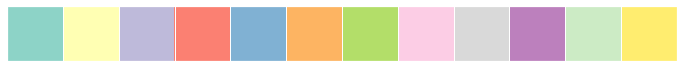

In [21]:
# Configuring IPython 
%load_ext autoreload
%autoreload 2

# Configuring matplotlib
%matplotlib inline

# Configuring warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Configuring color palette
sns.set()
colors = sns.color_palette("Set3")
sns.palplot(colors)
sns.set_style("whitegrid")
sns.set_style("ticks",{'axes.grid': True,'grid.color': '.95', 'grid.linestyle': '-', 'grid.zorder': 0})

# Verbosity
VERBOSE = False

## Loading family cross-validation results

In [22]:
# Families IDs
family_ids = [0, 1, 3, 7, 10, 14, 30, 32, 33, 43]

# Prepare test data filepaths
r_families = {
    f"famid{famid}": DiabNetReport(
        Ensemble(f"../results/models/families/famid{famid}/model-famid-{famid}-21-adamw-lc7-2021-10-05"),
        f"famid_{famid}_positivo_1000_random_0.csv",
        use_negatives=False
    ) for famid in family_ids 
}

## Plot 1: Barplot of family cross-validation metrics

[description]: What we find out with this plot?

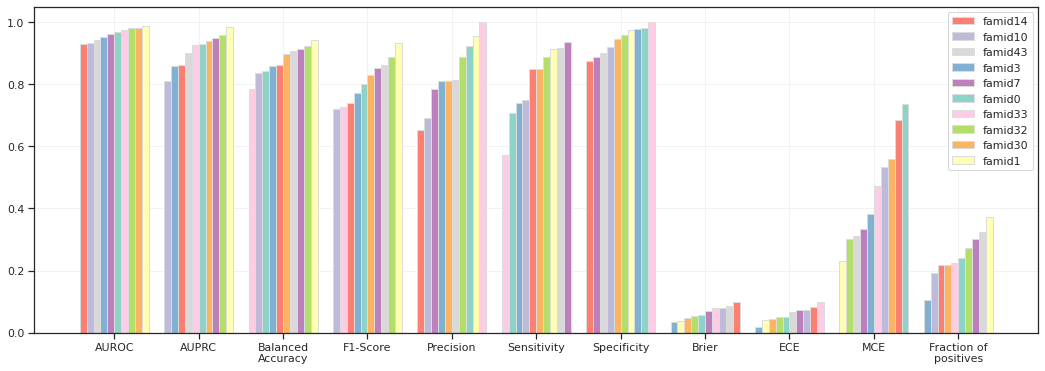

In [23]:
fig = plot_families_metrics(r_families)
if SAVE:
    for img_format in img_formats:
        fig.savefig(f"images/notebook4-plot1.{img_format}", bbox_inches="tight")

## Inspect Families Datasets

[description]

### Inspect age

#### Plot 2: Boxplot of ages of each family dataset

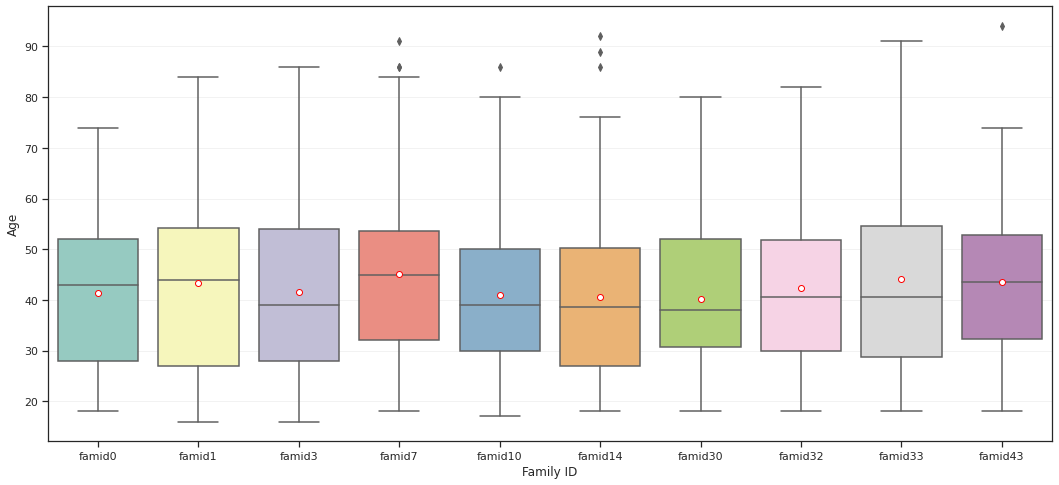

In [24]:
fig = plot_families_ages(r_families)
if SAVE:
    for img_format in img_formats:
        fig.savefig(f"images/notebook4-plot2.{img_format}", bbox_inches="tight")

### Inspect predictions

[description]

#### Plot 3: Plot of ages splitted by TP/TN/FP/FN

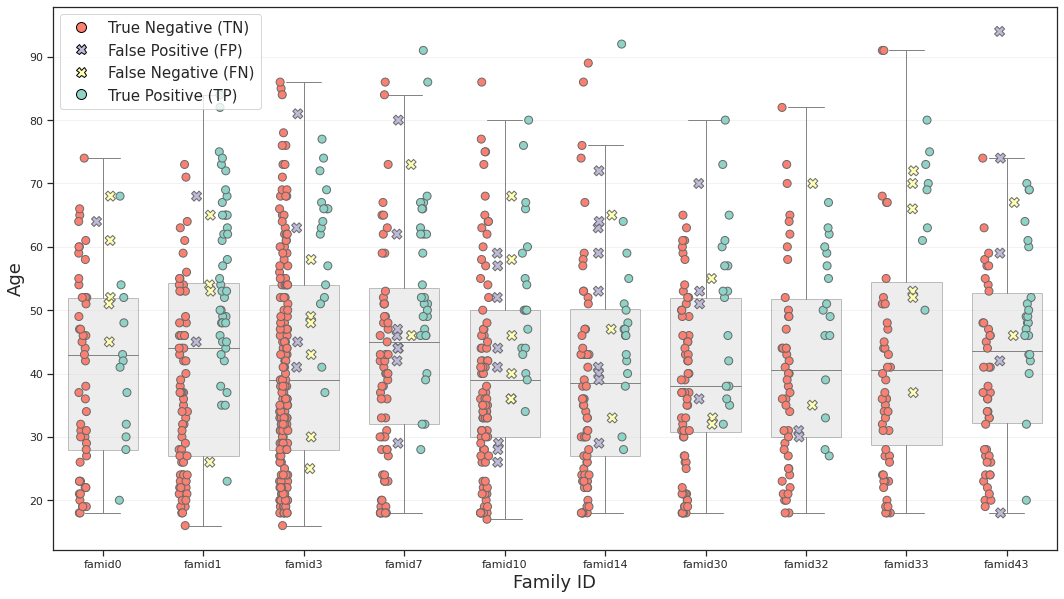

In [25]:
fig = plot_families_confusion(r_families, with_boxplot=True)
if SAVE:
    for img_format in img_formats:
        fig.savefig(f"images/notebook4-plot3.{img_format}", bbox_inches="tight")

#### Plot 4: Violin plot of prediction probability by correct/incorrect predictions

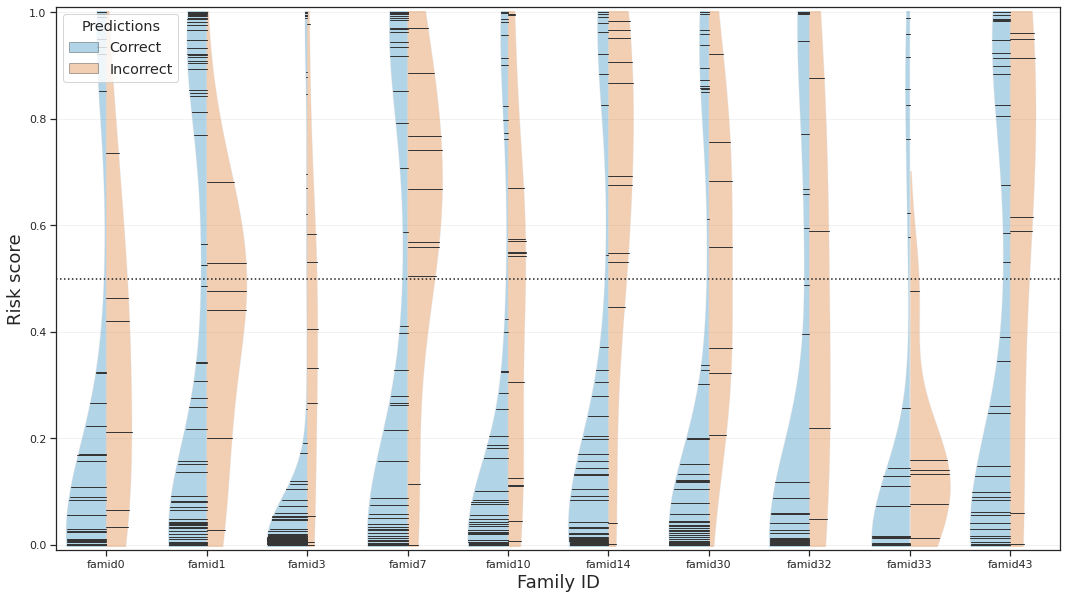

In [26]:
fig = plot_correct_by_prob(r_families)
if SAVE:
    for img_format in img_formats:
        fig.savefig(f"images/notebook4-plot4.{img_format}", bbox_inches="tight")

### Hierarchical clustering of features

In [27]:
# TODO refatorar e testar um clustering alternativo com snps selecionados pelo modelo

In [28]:
# obs: a unica familia que apresentou boa aglomeraçao foi a 'famid3'

In [29]:
import pandas as pd
import numpy

[description]

In [30]:
c_tmp = r_families['famid0'].dataset_test_unique.df.columns
c_snps = c_tmp[['snp' in i for i in c_tmp]]
c_famid = ['famid']
c_t2d = ['T2D']
c = c_snps.union(c_famid).union(c_t2d)


In [31]:
df_clt = pd.concat([r.dataset_test_unique.df[c] for r in r_families.values()])

In [32]:
row_colors = df_clt[c_famid]

In [33]:
idx = numpy.unique(row_colors.values.flatten()).tolist()

In [34]:
idx.index(43)

9

In [35]:
rc = [colors[idx.index(i)] for i in row_colors.values.flatten()]

In [36]:
idx[2]

3

In [37]:
rc = [colors[0 if i==idx[2] else 1] for i in row_colors.values.flatten()]

In [2]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

In [39]:
X = df_clt[c_snps].values

/home/ABTLUS/jose.pereira/projects/diabnet/.venv/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(1040.8000000000002, 0.5, 'Subjects')

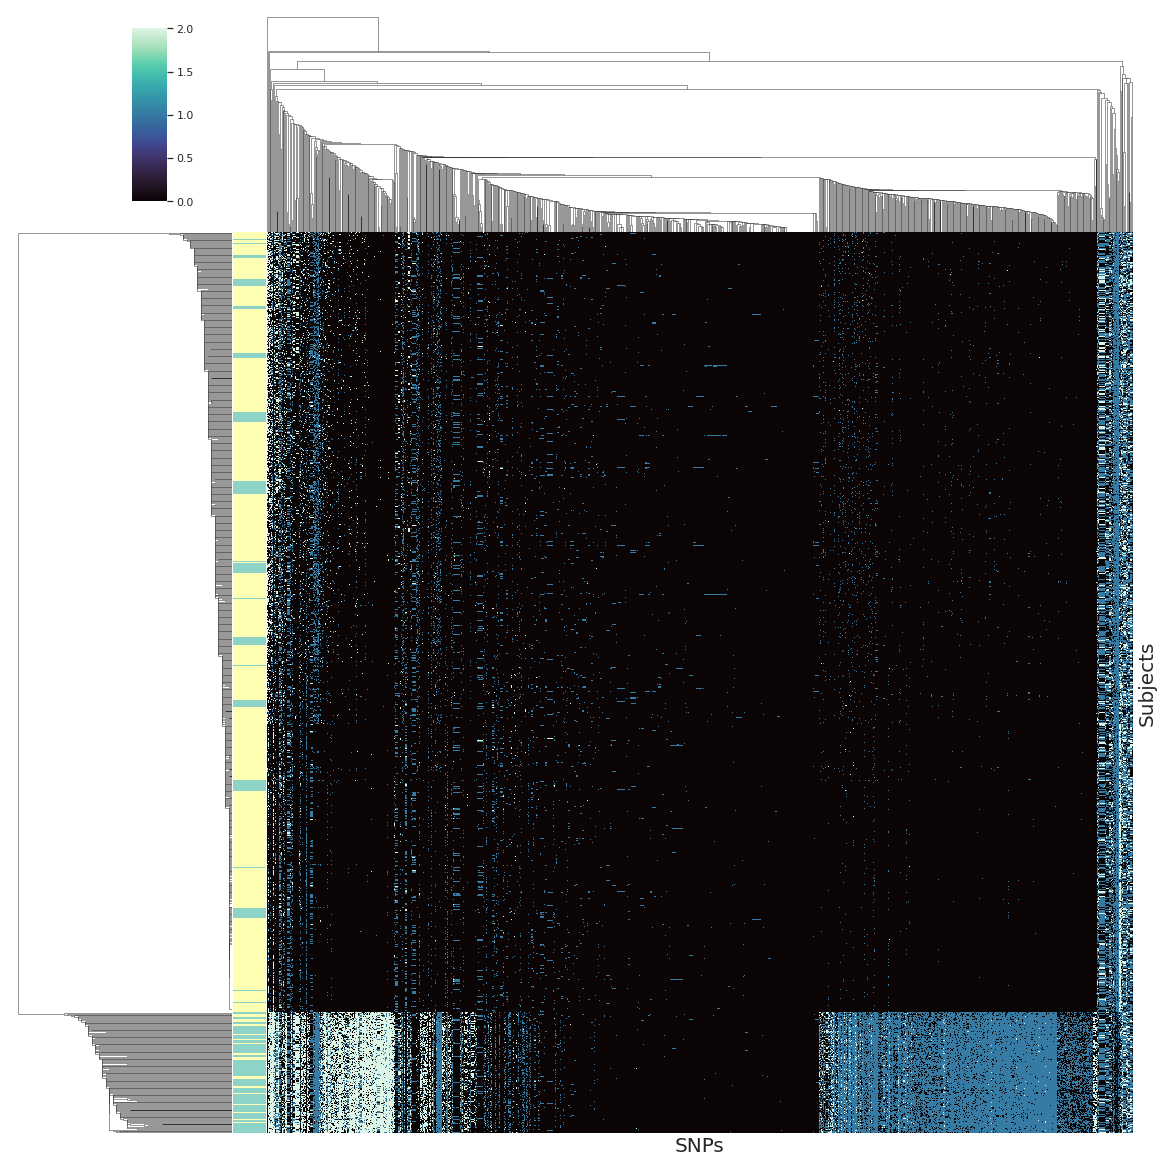

In [40]:
# Row colors
# row_colors = pd.Series(index, index=data.index).map(dict(zip(index, colors)))

# Plot heatmap
g = sns.clustermap(
#     data[data.columns[~data.columns.isin(['AGE','sex','mo_t2d','fa_t2d'])]].astype(float),
    df_clt[c_snps],# Ignore non-snp data
#     cmap='coolwarm',
    cmap='mako',
    # row_linkage using a distance for snps: dist(0,2) or dist(2,0) = 1 else 0
    row_linkage=linkage(pdist(X, lambda u, v: (abs(u-v)>1).sum()),method='single'),
#     metric="jaccard", 
    method="average",
    figsize=(16,16),
    cbar_pos=(0.12, 0.82, .03, .15),
    row_colors=rc,
#     palette=colors,
    yticklabels=False,
    xticklabels=False
)

# option 1
ax = g.ax_heatmap
ax.set_xlabel("SNPs", fontsize=20)
ax.set_ylabel("Subjects", fontsize=20)


/home/ABTLUS/jose.pereira/projects/diabnet/.venv/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(1040.8000000000002, 0.5, 'Subjects')

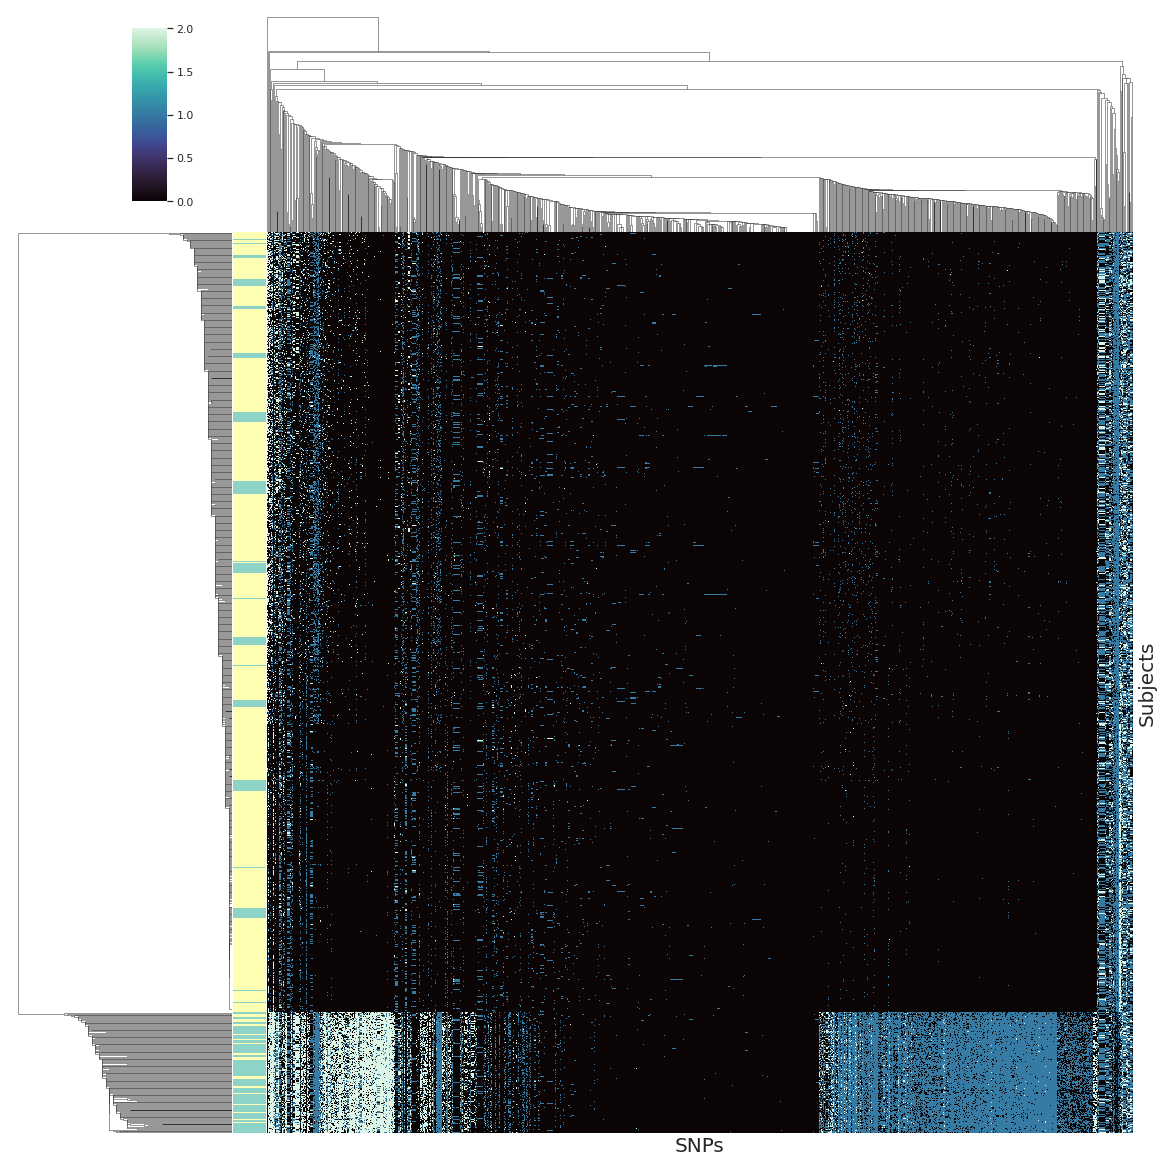

In [40]:
# Row colors
# row_colors = pd.Series(index, index=data.index).map(dict(zip(index, colors)))

# Plot heatmap
g = sns.clustermap(
#     data[data.columns[~data.columns.isin(['AGE','sex','mo_t2d','fa_t2d'])]].astype(float),
    df_clt[c_snps],# Ignore non-snp data
#     cmap='coolwarm',
    cmap='mako',
    # row_linkage using a distance for snps: dist(0,2) or dist(2,0) = 1 else 0
    row_linkage=linkage(pdist(X, lambda u, v: (abs(u-v)>1).sum()),method='single'),
#     metric="jaccard", 
    method="average",
    figsize=(16,16),
    cbar_pos=(0.12, 0.82, .03, .15),
    row_colors=rc,
#     palette=colors,
    yticklabels=False,
    xticklabels=False
)

# option 1
ax = g.ax_heatmap
ax.set_xlabel("SNPs", fontsize=20)
ax.set_ylabel("Subjects", fontsize=20)


In [13]:
import numpy as np
import seaborn as sns

In [9]:
X = np.random.randint(0,3,(100,1000))

In [11]:
# testes com uma funcao alternativa para computar distancia entre individuos baseado nos spns
# 0 se dist(0,0), dist(1,1), dist(2,2)
# 0 se dist(0,1), dist(1,0), dist(2,1), dist(1,2) pq é possivel um parentesco direto
# 1 se dist(0,2) ou dist(2,0) pq não seria possivel um parestesco direto (pais <-> filhos)
dsnp = pdist(X, lambda u, v: (abs(u-v)>1).sum()**2)

In [15]:
euclidean = pdist(X, 'euclidean')

/home/ABTLUS/jose.pereira/projects/diabnet/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

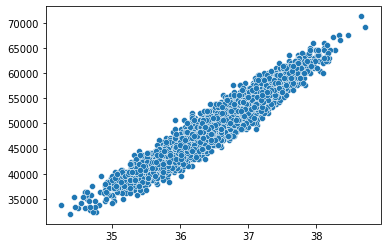

In [16]:
sns.scatterplot(euclidean, dsnp)

In [44]:
linkage(pdist(X, lambda u, v: (abs(u-v)>1).sum()),method='single')

array([[8.200e+01, 1.760e+02, 0.000e+00, 2.000e+00],
       [4.330e+02, 1.025e+03, 0.000e+00, 3.000e+00],
       [6.110e+02, 1.026e+03, 0.000e+00, 4.000e+00],
       ...,
       [2.350e+02, 2.045e+03, 4.700e+01, 1.360e+02],
       [3.890e+02, 2.046e+03, 4.800e+01, 1.370e+02],
       [1.911e+03, 2.047e+03, 6.100e+01, 1.025e+03]])

In [45]:
for f in r_families.values():
    print(len(f.dataset_test_unique.df))

71
124
216
103
125
92
92
66
62
74
